# Set Up (Don't read, just run)

In [30]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display

class DecisionTreeVisualizer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
        # Common widget parameters
        self.COMMON_STYLE = {'description_width': 'initial'}
        self.FEATURE_OPTIONS = X.columns
        self.SLIDER_PARAMS = {
            'min': 0,
            'max': 500,
            'step': 1,
            'description': 'Split Value:',
            'style': self.COMMON_STYLE
        }
        
        # Create widgets
        self.level1_feature, self.level1_value = self.create_split_widgets('level1')[:2]
        self.left_feature, self.left_value, self.left_checkbox = self.create_split_widgets('left')
        self.right_feature, self.right_value, self.right_checkbox = self.create_split_widgets('right')
        self.tree_output = widgets.Output()
        self.accuracy_widget = widgets.HTML(
            value='<h3 style="color: green; text-align: center;">Current Accuracy: NaN</h3>'
        )

    def create_split_widgets(self, name):
        """Create a feature dropdown and value slider pair for a split"""
        return (
            widgets.Dropdown(
                options=self.FEATURE_OPTIONS,
                description='Feature to split on:',
                style=self.COMMON_STYLE
            ),
            widgets.FloatSlider(**self.SLIDER_PARAMS),
            widgets.Checkbox(
                value=False,
                description='Left leaf is mpg=1',
                style=self.COMMON_STYLE
            )
        )

    def update_slider_range(self, *args):
        for feature, slider in [(self.level1_feature, self.level1_value),
                              (self.left_feature, self.left_value),
                              (self.right_feature, self.right_value)]:
            min_val = self.X[feature.value].min()
            max_val = self.X[feature.value].max()
            median_val = self.X[feature.value].median()
            
            slider.min = -1e6
            slider.max = 1e6
            slider.min = min_val
            slider.max = max_val
            slider.value = median_val

    def setup_dashboard(self):
        self.level1_feature.observe(self.update_slider_range, 'value')
        self.left_feature.observe(self.update_slider_range, 'value')
        self.right_feature.observe(self.update_slider_range, 'value')

        header1 = widgets.HTML("<h3>Level 1 Split</h3>")
        header2 = widgets.HTML("<h3>Level 2 Splits</h3>")
        output_header = widgets.HTML("<h2>Output Tree</h2")

        level1_box = widgets.VBox([self.level1_feature, self.level1_value],
                                layout=widgets.Layout(align_items='center', width='100%'))
        
        left_box = widgets.VBox([
            widgets.HTML("<b>Left Branch:</b>"),
            self.left_feature, 
            self.left_value, 
            self.left_checkbox
        ])
        
        right_box = widgets.VBox([
            widgets.HTML("<b>Right Branch:</b>"),
            self.right_feature, 
            self.right_value, 
            self.right_checkbox
        ])
        
        level2_box = widgets.HBox([left_box, right_box], 
                                layout=widgets.Layout(justify_content='space-around'))
        
        output_box = widgets.VBox([output_header, self.tree_output, self.accuracy_widget],
                                layout=widgets.Layout(align_items='center', width='100%'))
        
        display(header1)
        display(level1_box)
        display(header2)
        display(level2_box)
        display(output_box)
        self.update_slider_range()

    def evaluate_tree(self):
        predictions = []
        for i in range(len(self.X)):
            if self.X[self.level1_feature.value].iloc[i] < self.level1_value.value:
                if self.X[self.left_feature.value].iloc[i] < self.left_value.value:
                    pred = 1 if self.left_checkbox.value else -1
                else:
                    pred = -1 if self.left_checkbox.value else 1
            else:
                if self.X[self.right_feature.value].iloc[i] < self.right_value.value:
                    pred = 1 if self.right_checkbox.value else -1
                else:
                    pred = -1 if self.right_checkbox.value else 1
            predictions.append(pred)
        
        accuracy = (np.array(predictions) == self.y).mean()
        return accuracy

    def visualize_tree(self, *args):
        self.tree_output.clear_output(wait=True)
        
        with self.tree_output:
            print(f"                  {self.level1_feature.value} < {self.level1_value.value:.2f}")
            print("                 /                  \\")
            print(f"    {self.left_feature.value} < {self.left_value.value:.2f}          {self.right_feature.value} < {self.right_value.value:.2f}")
            print("      /        \\              /        \\")
            left_left = "mpg=1" if self.left_checkbox.value else "mpg=-1"
            left_right = "mpg=-1" if self.left_checkbox.value else "mpg=1"
            right_left = "mpg=1" if self.right_checkbox.value else "mpg=-1"
            right_right = "mpg=-1" if self.right_checkbox.value else "mpg=1"
            print(f"   {left_left}    {left_right}        {right_left}    {right_right}")
            
        accuracy = self.evaluate_tree()
        self.accuracy_widget.value = f'<h3 style="color: green; text-align: center;">Current Accuracy: {accuracy:.3f}</h3>'

    def run(self):
        self.setup_dashboard()
        for w in [self.level1_feature, self.level1_value, 
                 self.left_feature, self.left_value, 
                 self.right_feature, self.right_value,
                 self.left_checkbox, self.right_checkbox]:
            w.observe(self.visualize_tree, 'value')
        self.visualize_tree()

# Decision Trees: A Beginner's Guide

Imagine you're playing a game of "20 Questions" where you're trying to guess whether a car is fuel-efficient or not. That's essentially what a decision tree does! Let's break it down.

## What is a Decision Tree?

A decision tree is like a flowchart that helps make decisions by asking a series of yes/no questions. In your code example, you're trying to predict whether a car's MPG (miles per gallon) is high (1) or low (-1) based on features like:

- Number of cylinders
- Engine displacement
- Horsepower
- Weight
- Acceleration
- Model year
- Origin

## How Does it Work?

1. **Starting at the Root**: The tree starts with a single question (called the root node). For example: "Is the horsepower less than 130?"

2. **Following the Branches**: 
   - If YES → Go left
   - If NO → Go right

3. **Making Predictions**: Keep following the branches until you reach an end point (called a leaf), which gives you your prediction.

Here's a simple example:
```
                Is horsepower < 130?
               /                  \
              /                    \
           YES                      NO
           /                          \
    Is weight < 3000?          Is cylinders < 6?
      /           \              /            \
   MPG=1        MPG=-1        MPG=-1        MPG=1
(Efficient)  (Inefficient)  (Inefficient)  (Efficient)
```

## Why Use Decision Trees?

1. **Easy to Understand**: Unlike complex algorithms, you can explain a decision tree's logic in plain English.
2. **Powerful Foundation**: While simple decision trees are great for learning, techniques built upon them like Random Forests and XGBoost are among the most successful machine learning algorithms, often winning competitions and being used in industry.

## Your Turn: Build a Decision Tree!

Let's use the visualizations in the code to build our own decision tree. Look at the scatter plots and histograms and try to spot patterns:

1. **Understand the Data**:
    - Scatter plots help visualize relationships between two continuous variables (like displacement vs horsepower), with points colored by MPG to show where efficient/inefficient cars cluster
    - Simple histograms split by MPG (color) show the distribution of a single variable and can reveal natural thresholds where efficient cars become more common than inefficient ones
    - Faceted histograms are useful when examining how MPG patterns vary across categorical features like 'origin' that only take a few distinct values

2. **Find Good Splits**:
   Can you spot where efficient cars (MPG=1) cluster differently from inefficient ones (MPG=-1)? For example:
   - Is there a clear horsepower threshold that separates efficient from inefficient cars?
   - Do cars with different numbers of cylinders tend to have different MPG ratings?

3. **Try Your Tree**:
   Use the interactive widgets to build your tree:
   - Choose your first split (root node) based on the strongest pattern you see
   - Then choose two more splits (one for each branch) to refine your predictions
   - Watch how the accuracy changes as you adjust your splits!

The goal is to get the highest accuracy you can with just three questions (a depth-2 tree). Can you get above 80% accuracy?

In [26]:
auto_mpg = pd.read_csv('decision-trees-v1/auto-mpg.tsv', delimiter='\t')
X = auto_mpg.iloc[:, 1:-1] # Exclude mpg and car_name
y = auto_mpg.iloc[:, 0]

auto_mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,-1,8,304.0,193,4732,18.5,70,1,hi 1200d
1,-1,8,307.0,200,4376,15.0,70,1,chevy c20
2,-1,8,360.0,215,4615,14.0,70,1,ford f250
3,-1,8,318.0,210,4382,13.5,70,1,dodge d200
4,-1,8,350.0,180,3664,11.0,73,1,oldsmobile omega


In [29]:
import plotly.express as px

HISTROGRAM_KWARGS = {'nbins': 30, 'opacity': 0.5, 'barmode': 'group'}

px.scatter(data_frame=auto_mpg, x='displacement', y='horsepower', color='mpg').show()
px.histogram(data_frame=auto_mpg, x='acceleration', color='mpg', **HISTROGRAM_KWARGS).show()
px.histogram(data_frame=auto_mpg, facet_col='origin', x='acceleration', color='mpg', **HISTROGRAM_KWARGS).show()

In [28]:
# Create and run visualizer
visualizer = DecisionTreeVisualizer(X, y)
visualizer.run()

HTML(value='<h3>Level 1 Split</h3>')

HTML(value='<h3>Level 2 Splits</h3>')

## How Decision Trees Are Trained

Unlike our manual tree where we visually chose splits, scikit-learn's DecisionTreeClassifier 
automatically finds the best splits using these steps:

1. For each feature, try every possible split point
2. Calculate how well each split separates the classes (using metrics like Gini impurity or entropy)
3. Choose the feature and split point that gives the best separation
4. Repeat recursively for each branch until stopping criteria are met (like max depth or min samples per leaf)

Training Accuracy: 0.895
Testing Accuracy: 0.937


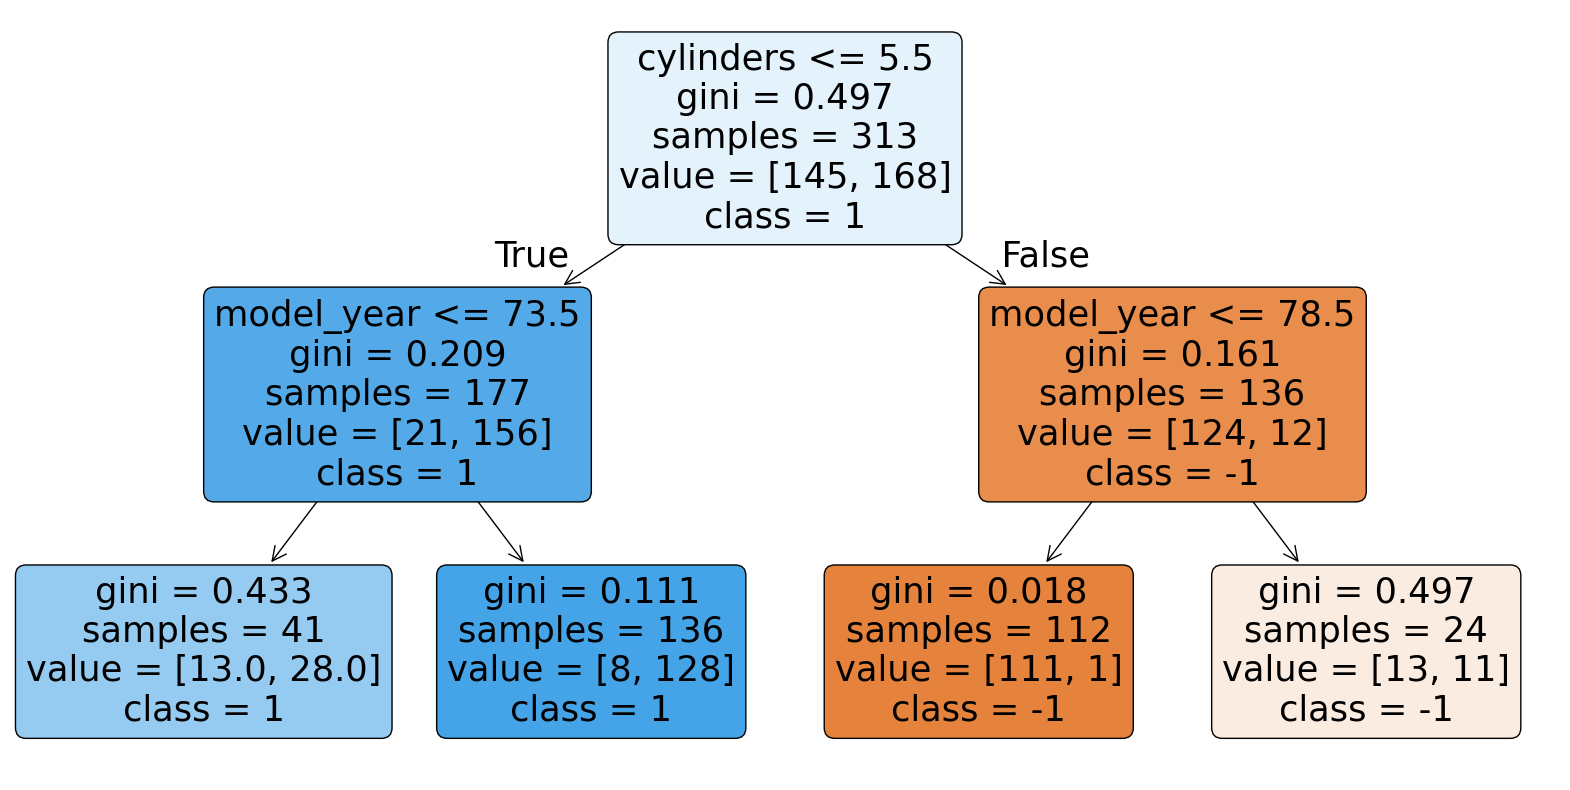

In [9]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train decision tree
dt = DecisionTreeClassifier(max_depth=2, random_state=42)
dt.fit(X_train, y_train)

# Get accuracy
train_accuracy = dt.score(X_train, y_train)
test_accuracy = dt.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Testing Accuracy: {test_accuracy:.3f}")

# Visualize the tree
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X.columns, class_names=['-1', '1'], filled=True, rounded=True)
plt.show()

We can get an intuition for why these splits were chosen by plotting cylinders, model year, and mpg together:

In [20]:
auto_mpg.sort_values(by='cylinders', inplace=True)
px.histogram(data_frame=auto_mpg, facet_col='cylinders', x='model_year', color='mpg', **HISTROGRAM_KWARGS).show()

## XGBoost: Machine Learning Magic

TODO: Make this explanation more accessible.

GBoost often achieves:
10-30% better accuracy than basic decision trees
Training speeds 10x faster than other boosting methods
This is why it's popular in:
Kaggle competitions
Financial predictions
Recommendation systems


#### 1. Sequential Learning (Boosting)
XGBoost builds trees sequentially, where each new tree focuses on correcting the mistakes of the combined previous trees. This is called "gradient boosting":

- Each tree learns to predict the residual errors from prior trees
- Predictions are combined additively, weighted by a learning rate
- The learning rate (typically < 0.1) controls how much each new tree contributes
- This process continues until prediction improvements plateau

#### 2. Preventing Overfitting
XGBoost implements multiple techniques to maintain good generalization:

1. **Tree Pruning**: 
   - Evaluates the gain of each potential split
   - Removes splits that don't meet a minimum gain threshold
   - Works backwards from leaf nodes to root

2. **Regularization**:
   - Penalizes model complexity through both number of leaves and prediction weights
   - Balances between fitting training data and maintaining simplicity
   - Automatically handles feature selection

#### 3. System Optimizations
XGBoost achieves superior training speed through:

1. **Parallel Processing**:
   - Parallelizes feature-wise split finding
   - Distributes tree construction across available cores
   - Supports distributed computing environments

2. **Memory Optimization**:
   - Block structure for out-of-core computation
   - Cache-aware access patterns
   - Compressed column storage format

These innovations combine to create an algorithm that's both more accurate and faster than traditional gradient boosting implementations, while requiring minimal hyperparameter tuning to achieve good results.

In [32]:
from xgboost import XGBClassifier
import numpy as np

# Convert -1 labels to 0 for XGBoost
y_train_xgb = np.where(y_train == -1, 0, y_train)
y_test_xgb = np.where(y_test == -1, 0, y_test)

# Train XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train_xgb)

# Get accuracy
xgb_train_accuracy = xgb.score(X_train, y_train_xgb)
xgb_test_accuracy = xgb.score(X_test, y_test_xgb)

print(f"XGBoost Training Accuracy: {xgb_train_accuracy:.3f}")
print(f"XGBoost Testing Accuracy: {xgb_test_accuracy:.3f}")

XGBoost Training Accuracy: 1.000
XGBoost Testing Accuracy: 0.937
